## Final Project Submission

Please fill out:
* Student name: David Braslow
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Eli
* Blog post URL:


# Overview

# Initialization

In [1]:
import numpy as np 
import pandas as pd 
import os
from tqdm import tqdm, trange
from sklearn.metrics import roc_auc_score
import pickle
import gc

In [2]:
tqdm.pandas()

In [3]:
BERT_MODEL = 'bert-base-uncased'
CASED = 'uncased' in BERT_MODEL
INPUT = 'raw_files/'
TEXT_COL = 'comment_text'
MAXLEN = 220

## Data Import

In [4]:
train = pd.read_csv(INPUT + 'train.csv').sample(frac = 0.05, random_state = 123)

In [5]:
test = pd.read_csv(INPUT + 'test.csv')

## BERT Embeddings

In [6]:
from pytorch_pretrained_bert import BertTokenizer
from pytorch_pretrained_bert.modeling import BertModel

In [7]:
BERT_FP = 'bert-base-uncased'

In [8]:
def get_bert_embed_matrix():
    bert = BertModel.from_pretrained(BERT_FP)
    bert_embeddings = list(bert.children())[0]
    bert_word_embeddings = list(bert_embeddings.children())[0]
    mat = bert_word_embeddings.weight.data.numpy()
    return mat

In [9]:
embedding_matrix = get_bert_embed_matrix()

In [10]:
embedding_matrix.shape

(30522, 768)

# Data Scrubbing

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90244 entries, 687256 to 1060568
Data columns (total 45 columns):
id                                     90244 non-null int64
target                                 90244 non-null float64
comment_text                           90244 non-null object
severe_toxicity                        90244 non-null float64
obscene                                90244 non-null float64
identity_attack                        90244 non-null float64
insult                                 90244 non-null float64
threat                                 90244 non-null float64
asian                                  20191 non-null float64
atheist                                20191 non-null float64
bisexual                               20191 non-null float64
black                                  20191 non-null float64
buddhist                               20191 non-null float64
christian                              20191 non-null float64
female             

In [12]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
687256,1082203,0.000000,"""And I always say that if I ever believed Cana...",0.0,0.0,0.166667,0.000000,0.0,0.0,0.0,...,317079,rejected,0,0,0,0,0,0.0,4,6
1728190,6241244,0.166667,"have to be fan today; not player. +3 or, +1.5,...",0.0,0.0,0.000000,0.166667,0.0,NaN,NaN,...,394471,approved,0,0,0,1,0,0.0,0,6
1733028,6247184,0.166667,It will help him get impeached for treason.,0.0,0.0,0.000000,0.000000,0.0,NaN,NaN,...,394751,approved,1,0,0,3,3,0.0,0,6
1073761,5428926,0.000000,To me there is a real disconnect when one says...,0.0,0.0,0.000000,0.000000,0.0,NaN,NaN,...,344947,approved,1,0,0,10,0,0.0,0,4
541700,905935,0.000000,We have a spending problem John. I refuse to a...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,164337,approved,0,0,0,1,1,0.0,4,4


In [13]:
train.loc[687256]['comment_text']

'"And I always say that if I ever believed Canada was really the Canada of Stephen Harper and we were going against abortion and going against gay marriage, and we were going backward in 10,000 different ways, maybe I\'d think of wanting to make Quebec a country." ~  Justin Trudeau when he was an MP during a radio interview with  host Franco Nuovo in February 2012.\n\nDuring the talk show, when Nuovo expressed surprise at Trudeau\'s remarks, Trudeau doubled down: "Oh yes, absolutely. If I no longer recognized Canada, I know my own values."\n\nHowever to be fair to the Tater Tot he was but a callow youth of 41 years of age at the time... just a seed potato eh?\n\nThat sound you heard was Pierre Trudeau turning over in his grave.'

In [14]:
test.head()

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


## Cleaning Text

In [15]:
def clean_text(x):
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~&' + '“”’':
        x = x.replace(punct, '')
    return x

In [16]:
train['text_clean'] = train['comment_text'].progress_apply(clean_text)
train['text_clean'].head()

100%|█████████████████████████████████████████████████████████████████████████| 90244/90244 [00:01<00:00, 69472.01it/s]


687256     And I always say that if I ever believed Canad...
1728190    have to be fan today not player 3 or 15 take y...
1733028           It will help him get impeached for treason
1073761    To me there is a real disconnect when one says...
541700     We have a spending problem John I refuse to ac...
Name: text_clean, dtype: object

## Tokenizing

In [17]:
#Import BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case = CASED)

In [18]:
train['text_tokens'] = train['text_clean'].progress_apply(tokenizer.tokenize)
train['text_tokens'].head()

100%|███████████████████████████████████████████████████████████████████████████| 90244/90244 [01:59<00:00, 755.66it/s]


687256     [and, i, always, say, that, if, i, ever, belie...
1728190    [have, to, be, fan, today, not, player, 3, or,...
1733028    [it, will, help, him, get, imp, ##ea, ##ched, ...
1073761    [to, me, there, is, a, real, disco, ##nne, ##c...
541700     [we, have, a, spending, problem, john, i, refu...
Name: text_tokens, dtype: object

## Encoding

### Checking Vocabulary Coverage

In [19]:
tokenizer.save_vocabulary('vocab')
bert_vocab_file = open('vocab\\vocab.txt', encoding='utf-8')
bert_vocab_list = bert_vocab_file.read().split(sep = '\n')
bert_vocab_dict = {x: True for x in bert_vocab_list}

In [20]:
# https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [21]:
train_sentences = train['text_tokens'].values
train_vocab = build_vocab(train_sentences)

100%|█████████████████████████████████████████████████████████████████████████| 90244/90244 [00:01<00:00, 55466.47it/s]


In [22]:
import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [23]:
check_coverage(train_vocab, bert_vocab_dict)[0:20]

100%|███████████████████████████████████████████████████████████████████████| 25231/25231 [00:00<00:00, 1051326.09it/s]


Found embeddings for 100.00% of vocab
Found embeddings for  100.00% of all text


[]

### Encoding Comments

In [24]:
train['text_ids'] = train['text_tokens'].progress_apply(tokenizer.convert_tokens_to_ids)
train['text_ids'].head(10)

100%|█████████████████████████████████████████████████████████████████████████| 90244/90244 [00:01<00:00, 51567.88it/s]


687256     [1998, 1045, 2467, 2360, 2008, 2065, 1045, 241...
1728190    [2031, 2000, 2022, 5470, 2651, 2025, 2447, 101...
1733028    [2009, 2097, 2393, 2032, 2131, 17727, 5243, 76...
1073761    [2000, 2033, 2045, 2003, 1037, 2613, 12532, 10...
541700     [2057, 2031, 1037, 5938, 3291, 2198, 1045, 102...
900691     [1045, 1049, 2025, 1037, 5470, 1997, 8398, 200...
393193     [2481, 1056, 2022, 1037, 2488, 2447, 2652, 200...
1121977    [2045, 2024, 1037, 2843, 1997, 2822, 2231, 512...
1411658    [4067, 2017, 2005, 2023, 23259, 14764, 2009, 2...
300499     [1996, 3145, 2003, 2008, 2017, 3685, 5860, 200...
Name: text_ids, dtype: object

### Clipping

In [25]:
def id_clip(ids, num_ids = MAXLEN):
    ids_clipped = list(np.zeros(num_ids, dtype=np.int))
    i = 0
    while (i < num_ids) & (i < len(ids)):
        ids_clipped[i] = ids[i]
        i += 1
    return np.array(ids_clipped)

In [26]:
train['text_ids_clipped'] = train['text_ids'].progress_apply(id_clip)
train['text_ids_clipped'].head()

100%|█████████████████████████████████████████████████████████████████████████| 90244/90244 [00:04<00:00, 18703.41it/s]


687256     [1998, 1045, 2467, 2360, 2008, 2065, 1045, 241...
1728190    [2031, 2000, 2022, 5470, 2651, 2025, 2447, 101...
1733028    [2009, 2097, 2393, 2032, 2131, 17727, 5243, 76...
1073761    [2000, 2033, 2045, 2003, 1037, 2613, 12532, 10...
541700     [2057, 2031, 1037, 5938, 3291, 2198, 1045, 102...
Name: text_ids_clipped, dtype: object

# Exploring the Data

In [27]:
import matplotlib.pyplot as plt

## Comments

In [28]:
train['text_id_len'] = train['text_ids'].progress_apply(len)
train['text_id_len'].describe()

100%|████████████████████████████████████████████████████████████████████████| 90244/90244 [00:00<00:00, 524671.72it/s]


count    90244.000000
mean        56.586765
std         50.380106
min          0.000000
25%         18.000000
50%         39.000000
75%         79.000000
max        307.000000
Name: text_id_len, dtype: float64

(array([1.8362e+04, 1.8826e+04, 1.3674e+04, 9.1280e+03, 6.7160e+03,
        5.3300e+03, 3.6030e+03, 2.9470e+03, 2.4050e+03, 1.9530e+03,
        1.9030e+03, 2.9650e+03, 1.9970e+03, 4.0700e+02, 2.6000e+01,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.  ,  15.35,  30.7 ,  46.05,  61.4 ,  76.75,  92.1 , 107.45,
        122.8 , 138.15, 153.5 , 168.85, 184.2 , 199.55, 214.9 , 230.25,
        245.6 , 260.95, 276.3 , 291.65, 307.  ]),
 <a list of 20 Patch objects>)

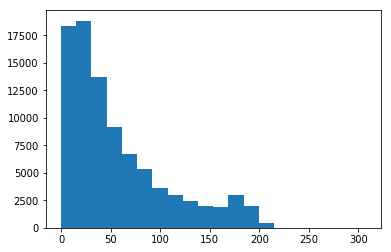

In [29]:
plt.hist(train['text_id_len'].values, bins=20)

## Toxicity (Target)

count    90244.000000
mean         0.102996
std          0.196619
min          0.000000
25%          0.000000
50%          0.000000
75%          0.166667
max          1.000000
Name: target, dtype: float64

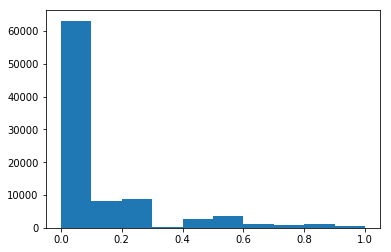

In [30]:
plt.hist(train['target'])
train['target'].describe()

In [31]:
np.mean(np.round(train['target'].values))

0.058386153096050705

### Toxicity by Subgroup

In [32]:
identity_columns = ['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']
train[identity_columns].mean()

male                             0.105813
female                           0.129556
homosexual_gay_or_lesbian        0.025052
christian                        0.093628
jewish                           0.018585
muslim                           0.049300
black                            0.034535
white                            0.055545
psychiatric_or_mental_illness    0.012549
dtype: float64

In [33]:
for identity in identity_columns:
    identity_df = train[train[identity] >= 0.5]
    identity_tox = np.round(identity_df['target'].values)
    n_toxic = sum(identity_tox)
    n_tot = len(identity_tox)
    pct_toxic = np.round(n_toxic/n_tot * 100, decimals = 1) 
    print(f"{identity}: {pct_toxic}%")

male: 11.2%
female: 9.1%
homosexual_gay_or_lesbian: 19.2%
christian: 5.3%
jewish: 8.4%
muslim: 13.5%
black: 22.2%
white: 18.2%
psychiatric_or_mental_illness: 11.5%


In [34]:
identity_columns_long = ['asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu', 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability', 'jewish', 'latino', 'male', 'muslim', 'other_disability', 'other_gender', 'other_race_or_ethnicity', 'other_religion', 'other_sexual_orientation', 'physical_disability', 'psychiatric_or_mental_illness', 'transgender', 'white']
for identity in identity_columns_long:
    identity_df = train[train[identity] >= 0.5]
    identity_tox = np.round(identity_df['target'].values)
    n_toxic = sum(identity_tox)
    n_tot = len(identity_tox)
    if n_tot == 0:
        continue
    pct_toxic = np.round(n_toxic/n_tot * 100, decimals = 1) 
    print(f"{identity}: {pct_toxic}%")

asian: 11.4%
atheist: 6.8%
bisexual: 25.0%
black: 22.2%
buddhist: 0.0%
christian: 5.3%
female: 9.1%
heterosexual: 21.3%
hindu: 6.7%
homosexual_gay_or_lesbian: 19.2%
intellectual_or_learning_disability: 0.0%
jewish: 8.4%
latino: 15.7%
male: 11.2%
muslim: 13.5%
other_disability: 50.0%
other_race_or_ethnicity: 25.0%
other_religion: 0.0%
physical_disability: 0.0%
psychiatric_or_mental_illness: 11.5%
transgender: 15.1%
white: 18.2%


## Toxic Words

### Identify Important Words with TF-IDF

In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

count_vectorizer = CountVectorizer(max_features=20000)
count_vectorizer.fit(train['comment_text'].values)
top_20000_words = count_vectorizer.get_feature_names()
top_20000_words[0:10]

['00', '000', '001', '01', '02', '03', '04', '05', '06', '07']

In [36]:
gc.collect()
count_mat = count_vectorizer.transform(train['comment_text'].values)

In [42]:
np.sum((count_mat[:,0] >= 1).toarray())

182

In [60]:
df = train[['target']]
df['target'] = df['target'].apply(np.round)
word_dict = {}
for i, word in enumerate(top_20000_words):
    count_docs = count_mat[:,i] >= 1
    num_docs = np.sum(count_docs)
    if num_docs < 100:
        # print(word, num_docs)
        continue
    pres_mat = count_docs.toarray().flatten()
    df['pres'] = pd.Series(pres_mat)
    # print(word, num_docs, df.groupby('pres').mean())
    word_dict[word] = (num_docs, df.groupby('pres').mean().values[0,0],  df.groupby('pres').mean().values[1, 0])
print(word_dict)

C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\david\Anaconda3\envs\mod4\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


{'00': (182, 0.05674397658185094, 0.0), '000': (1324, 0.05700658641835112, 0.02127659574468085), '01': (115, 0.05665467625899281, 0.0), '04': (101, 0.05669291338582677, 0.0), '06': (107, 0.05645524066576698, 0.25), '08': (118, 0.05669291338582677, 0.0), '10': (1490, 0.05639269406392694, 0.07142857142857142), '100': (997, 0.05618744313011829, 0.09259259259259259), '1000': (146, 0.05668016194331984, 0.0), '11': (505, 0.05633484162895928, 0.1), '12': (590, 0.056890299184043515, 0.02631578947368421), '13': (278, 0.05684637942702459, 0.0), '14': (267, 0.056782334384858045, 0.0), '15': (657, 0.0570006785795069, 0.0), '150': (151, 0.056731202161188654, 0.0), '16': (338, 0.056897719575524947, 0.0), '17': (253, 0.056807935076645624, 0.0), '18': (350, 0.056795131845841784, 0.0), '19': (193, 0.05651880207160549, 0.1111111111111111), '1st': (163, 0.05671843349088454, 0.0), '20': (1060, 0.056954844565464034, 0.023255813953488372), '200': (272, 0.056769542689795, 0.0), '2000': (141, 0.05670567056705

In [61]:
word_freq = pd.DataFrame.from_dict(word_dict, orient = 'index', columns = ['Count', 'PctNonToxic', 'PctToxic'])
word_freq = word_freq.sort_values('PctToxic', ascending = False)
word_freq.head(20)

,Count,PctNonToxic,PctToxic
inability,100,0.056417,1.000000
flow,130,0.056417,1.000000
lay,194,0.056417,1.000000
helpful,109,0.056218,0.666667
contempt,101,0.056430,0.500000
lynch,109,0.056430,0.500000
trillion,140,0.056430,0.500000
savings,228,0.056031,0.500000
ryan,156,0.056230,0.500000
donors,105,0.056031,0.500000


# Modeling the Data

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.losses import binary_crossentropy
from keras import backend as K
import keras.layers as L
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model
from keras.optimizers import Adam

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf

In [ ]:
identity_columns = ['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']
y_identities = (train[identity_columns] >= 0.5).astype(int).values

# Overall
weights = np.ones((len(train),)) / 4
# Subgroup
weights += (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) / 4
# Background Positive, Subgroup Negative
weights += (( (train['target'].values>=0.5).astype(bool).astype(np.int) +
   (train[identity_columns].fillna(0).values<0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
# Background Negative, Subgroup Positive
weights += (( (train['target'].values<0.5).astype(bool).astype(np.int) +
   (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4

loss_weight = 1.0 / weights.mean()

print(weights.shape)
print(loss_weight)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(weights, range=(0,1))

In [ ]:
y_train = np.vstack([(train['target'].values>=0.5).astype(np.int),weights]).T
y_aux_train = train[['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']].values

x_train = np.vstack(train['text_ids_clipped'].to_numpy())

In [ ]:
tr_ind, val_ind = train_test_split(list(range(len(x_train))) ,test_size = 0.05, random_state = 123)

In [ ]:
print(y_train.shape, y_aux_train.shape, x_train.shape)

In [ ]:
BATCH_SIZE = 128
EPOCHS = 8
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS

In [ ]:
tf.reset_default_graph()

In [ ]:
def build_model(embedding_matrix, num_aux_targets, loss_weight):
    '''
    credits go to: https://www.kaggle.com/thousandvoices/simple-lstm/
    '''
    words = Input(shape=(MAXLEN,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.5)(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([GlobalMaxPooling1D()(x),GlobalAveragePooling1D()(x),])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    aux_result = Dense(num_aux_targets, activation='sigmoid')(hidden)
    
    model = Model(inputs=words, outputs=[result, aux_result])
    model.compile(loss=[custom_loss,'binary_crossentropy'], loss_weights=[loss_weight, 1.0], optimizer='adam')

    return model

In [ ]:
def custom_loss(y_true, y_pred):
    return binary_crossentropy(K.reshape(y_true[:,0],(-1,1)), y_pred) * y_true[:,1]

In [ ]:
build_model(embedding_matrix, y_aux_train.shape[-1], loss_weight).summary()

In [ ]:
# https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/90527#latest-527799
import numpy as np
from sklearn.metrics import roc_auc_score


class JigsawEvaluator:

    def __init__(self, y_true, y_identity, power=-5, overall_model_weight=0.25):
        self.y = (y_true >= 0.5).astype(int)
        self.y_i = (y_identity >= 0.5).astype(int)
        self.n_subgroups = self.y_i.shape[1]
        self.power = power
        self.overall_model_weight = overall_model_weight

    @staticmethod
    def _compute_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except ValueError:
            return np.nan

    def _compute_subgroup_auc(self, i, y_pred):
        mask = self.y_i[:, i] == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bpsn_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bnsp_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y != 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def compute_bias_metrics_for_model(self, y_pred):
        records = np.zeros((3, self.n_subgroups))
        for i in range(self.n_subgroups):
            records[0, i] = self._compute_subgroup_auc(i, y_pred)
            records[1, i] = self._compute_bpsn_auc(i, y_pred)
            records[2, i] = self._compute_bnsp_auc(i, y_pred)
        return records

    def _calculate_overall_auc(self, y_pred):
        return roc_auc_score(self.y, y_pred)

    def _power_mean(self, array):
        total = sum(np.power(array, self.power))
        return np.power(total / len(array), 1 / self.power)

    def get_final_metric(self, y_pred):
        bias_metrics = self.compute_bias_metrics_for_model(y_pred)
        bias_score = np.average([
            self._power_mean(bias_metrics[0]),
            self._power_mean(bias_metrics[1]),
            self._power_mean(bias_metrics[2])
        ])
        overall_score = self.overall_model_weight * self._calculate_overall_auc(y_pred)
        bias_score = (1 - self.overall_model_weight) * bias_score
        return overall_score + bias_score

In [ ]:
#checkpoint_predictions = []
checkpoint_val_preds = []
eval_scores = []
train_losses = []
val_losses = []
weights = []

model = build_model(embedding_matrix, y_aux_train.shape[-1],loss_weight)
for global_epoch in range(EPOCHS):
    history = model.fit(x_train[tr_ind],[y_train[tr_ind], y_aux_train[tr_ind]],validation_data = (x_train[val_ind],[y_train[val_ind], y_aux_train[val_ind]]),
        batch_size=BATCH_SIZE,
        epochs=1,
        verbose=1,
        callbacks=[
            LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** global_epoch))
        ]
    )
    #checkpoint_predictions.append(model.predict(x_test, batch_size=BATCH_SIZE)[0].flatten())
    gc.collect()
    val_preds = model.predict(x_train[val_ind], batch_size=BATCH_SIZE)[0].flatten()
    JE = JigsawEvaluator(y_train[val_ind][:,0],y_identities[val_ind])
    eval_scores.append(JE.get_final_metric(val_preds))
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])


In [ ]:
#Your code here; visualize the training / validation history associated with fitting the model.
epch = range(1, EPOCHS + 1)
plt.plot(epch, train_losses, 'g', label='Training Loss')
plt.plot(epch, val_losses, 'r', label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.figure()
plt.plot(epch, eval_scores, 'b', label='Evaluation Scores')
plt.legend()
plt.show()

In [ ]:
plt.hist(val_preds)